In [13]:
import torch
from torch import nn
import torch.optim as optim
import tkinter as tk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backend_bases import MouseEvent
import ipywidgets as widgets
from ipywidgets import interact, interactive
import torch
from PIL import Image, ImageDraw
import torchvision
import PIL.ImageOps

In [14]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(7 * 7 * 64, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = x.view(-1, 7 * 7 * 64)  # Flatten the tensor
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

# Save as "main.ipynb"
model = SimpleCNN()

In [15]:
# Do not train the model, only use it
model.eval()

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu") 
    print("GPU is not available")

model.to(device)

GPU is available


SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [16]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
def load_checkpoint(model, optimizer, file_path='checkpoint.pth'):
    # Load the checkpoint
    checkpoint = torch.load(file_path)
    
    # Load the model and optimizer state dictionaries
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    # Optionally load the epoch and loss (to resume training)
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    
    print(f"Checkpoint loaded from {file_path}")
    print(f"Resuming from epoch {epoch} with loss {loss}")
    
    return model, optimizer, epoch, loss

model, optimizer, epoch, loss = load_checkpoint(model, optimizer, 'checkpoint_epoch_4.pth')

Checkpoint loaded from checkpoint_epoch_4.pth
Resuming from epoch 4 with loss 0.025067206472158432


C:\Users\Shlomi\AppData\Local\Temp\ipykernel_20788\2716207042.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_path)


In [18]:
def preprocess_image(filename):
    """ Preprocess the image to be compatible with the model """
    # Load the image
    img = Image.open(filename)
    
    img = img.convert('L') # Convert to grayscale
    img = PIL.ImageOps.invert(img) # Invert the colors

    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize((28, 28)),
        torchvision.transforms.ToTensor()
    ])
    tensor_image = transforms(img).to(device) # Apply transformations and move to GPU if available

    # Save tensor image
    torchvision.utils.save_image(tensor_image, 'processed_image.jpg')

    return tensor_image

def predict(tensor_image):
    """Run the model on the image and return the predicted label"""
    output = model(tensor_image)
    _, predicted_label = torch.max(output, 1)
    
    return predicted_label.item()

In [19]:
class DrawingApp:
    def __init__(self, master):
        self.master = master
        self.master.title("Interactive Digit Classifier")
        self.master.geometry("800x600")

        width = 280 # Canvas width
        height = 280 # Canvas height
        self.width = width
        self.height = height
        white = (255, 255, 255)
        
        # Initialize drawing settings
        self.brush_size = 12 # Default brush size
        self.drawing = False

        # Create canvas for drawing
        self.canvas = tk.Canvas(self.master, width=width, height=height, bg="white")
        self.canvas.pack(pady=20)

        self.canvas_image = Image.new("RGB", (width, height), white)
        self.image_draw = ImageDraw.Draw(self.canvas_image) # Not visible on the screen, we use it to convert to image later

        # Brush size selection
        self.brush_size_label = tk.Label(self.master, text="Select Brush Size:")
        self.brush_size_label.pack()

        # Brush size scale slider
        self.brush_size_slider = tk.Scale(self.master, from_=1, to_=20, orient="horizontal")
        self.brush_size_slider.set(self.brush_size)
        self.brush_size_slider.pack(pady=10)

        # Button to clear the canvas
        self.clear_button = tk.Button(self.master, text="Clear", command=self.clear_canvas)
        self.clear_button.pack(pady=10)

        # Label to display the prediction
        self.prediction_label = tk.Label(self.master, text="Prediction: ", font=("Arial", 12))
        self.prediction_label.pack(pady=10)

        # Bind mouse events for drawing
        self.canvas.bind("<Button-1>", self.start_drawing)
        self.canvas.bind("<B1-Motion>", self.draw)
        self.canvas.bind("<ButtonRelease-1>", self.stop_drawing)

    def start_drawing(self, event):
        """Start drawing on mouse button press"""
        self.drawing = True
        self.previous_x = event.x
        self.previous_y = event.y

    def draw(self, event):
        """Draw on canvas as mouse moves"""
        if self.drawing:
            brush_size = self.brush_size_slider.get()
            self.canvas.create_oval(
                event.x - brush_size, event.y - brush_size, 
                event.x + brush_size, event.y + brush_size, 
                fill="black", outline="black"
            )
            self.image_draw.ellipse(
                [event.x - brush_size, event.y - brush_size, event.x + brush_size, event.y + brush_size], 
                fill="black")

            self.evaluate_drawing()

    def stop_drawing(self, event):
        """Stop drawing on mouse button release"""
        self.drawing = False

    def clear_canvas(self):
        """Clear the canvas"""
        self.canvas.delete("all")
        # Fill self.canvas_image with white color but do not create a new Image object (because we need the reference)
        white = (255, 255, 255)
        self.image_draw.rectangle([0, 0, self.width, self.height], fill=white)

    def update_brush_size(self):
        """Update the brush size from the slider"""
        self.brush_size = self.brush_size_slider.get()
    
    def evaluate_drawing(self):
        """Capture the canvas drawing, preprocess it, and evaluate with the model"""

        # Save the canvas to a file
        filename = "canvas.jpg"
        self.canvas_image.save(filename)

        # Preprocess the image
        tensor_image = preprocess_image(filename)

        # Run the model on the processed image
        prediction = predict(tensor_image)
        print(f"Prediction: {prediction}")
        
        # Display the prediction
        self.prediction_label.config(text=f"Prediction: {prediction}")


In [20]:
# Create the main Tkinter window
root = tk.Tk()
app = DrawingApp(root)

# Start the Tkinter event loop
root.mainloop()
print("finish")

Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Prediction: 7
Predic

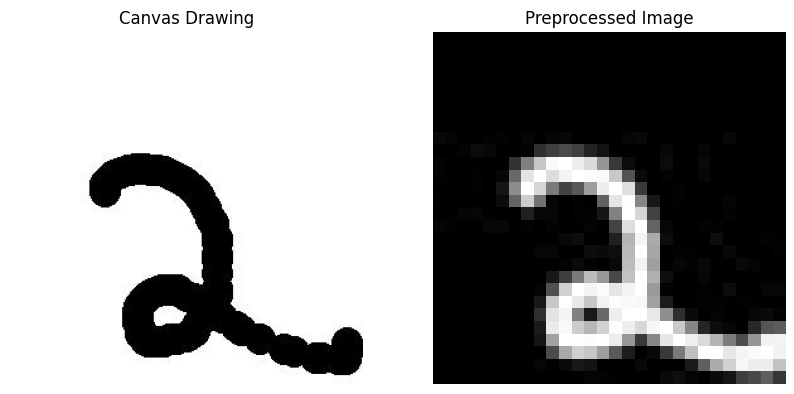

In [21]:

# Display the canvas and preprocessed_images
canvas_image = Image.open("canvas.jpg")
processed_image = Image.open("processed_image.jpg")

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(canvas_image)
ax[0].axis('off')
ax[0].set_title("Canvas Drawing")
ax[1].imshow(processed_image, cmap='gray')
ax[1].axis('off')
ax[1].set_title("Preprocessed Image")
plt.show()


In [22]:
# Check mean, variance of the image
processed_image = Image.open("processed_image.jpg")

transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
tensor_image = transforms(processed_image).to(device)
print(f"Mean: {tensor_image.mean() * 256}")

# Print max min
print(f"Max: {tensor_image.max() * 256}")
print(f"Min: {tensor_image.min() * 256}")

Mean: 37.639373779296875
Max: 256.0
Min: 0.0
